# Covid-19 Tweets Text Mining

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alenchen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alenchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/alenchen/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/alenchen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Load Data

In [2]:
trainDataPath = './Corona_train.csv'
rawTrainData = pd.read_csv(trainDataPath, encoding='latin-1')

testDataPath = './Corona_test.csv'
rawTestData = pd.read_csv(testDataPath, encoding='latin-1')

## Statistics

In [5]:
sentiments = rawTrainData['Sentiment'].unique()
print("Possible sentiments:")
print(sentiments)

Possible sentiments:
['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive']


Distribution of all sentiments.

<AxesSubplot:>

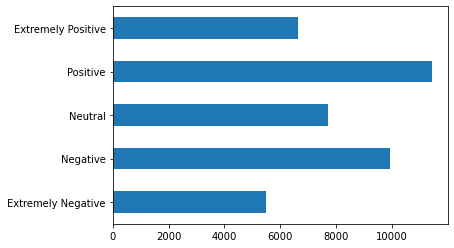

In [4]:
sentiDistribution = rawTrainData['Sentiment'].value_counts()
# sentiDistribution.plot.barh(x='Sentiments', y='Numbers')
sentiDistribution = sentiDistribution.reindex(index=['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'])
sentiDistribution.plot.barh(x='Sentiments', y='Numbers')

Pandas DataFrame data type

In [6]:
dataTypes = rawTrainData.dtypes
print(dataTypes)

UserName          int64
ScreenName        int64
Location         object
TweetAt          object
OriginalTweet    object
Sentiment        object
dtype: object


Most popular sentiment per day.

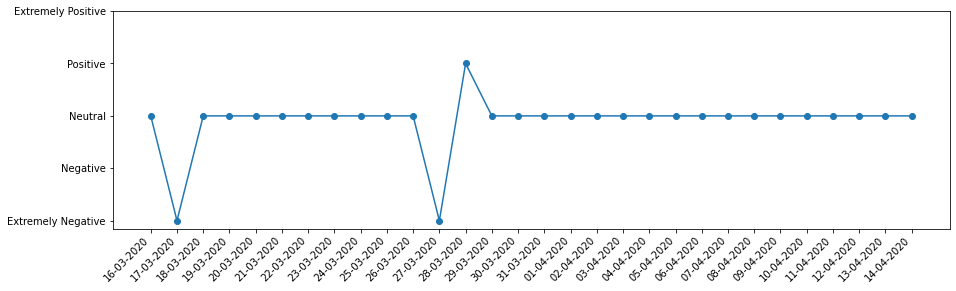

In [7]:
dates = rawTrainData['TweetAt'].unique()
dailySentiDistribution = pd.DataFrame({'date': pd.Series(dtype=object), 'senti': pd.Series(dtype=object)})
for date in dates:
  dailyData = rawTrainData[(rawTrainData['TweetAt'] == date)]
  mostPopSenti = dailyData['Sentiment'].value_counts().index[0]
  dailyMostPopSentiData = pd.DataFrame({'date': [date], 'senti': [mostPopSenti]})
  dailySentiDistribution = pd.concat([dailySentiDistribution, dailyMostPopSentiData], ignore_index=True)

sentiMap = {'Extremely Negative': 0, 'Negative': 1, 'Neutral': 2 , 'Positive': 3, 'Extremely Positive': 4}
dailySentiDistribution['senti'] = dailySentiDistribution['senti'].apply(lambda senti: sentiMap[senti])
# print(dailySentiDistribution)
plt.figure(figsize = (15,4))
plt.plot(dailySentiDistribution['date'], dailySentiDistribution['senti'], marker='o')
plt.yticks(range(1, 6), ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'])
plt.xticks(rotation=45, ha='right')
plt.show()

## Text Preprocess

In [8]:
def Preprocess(rawDataDf: pd.DataFrame) -> pd.DataFrame:
    dataDf = rawDataDf[['OriginalTweet', 'Sentiment']].copy()
    dataDf = dataDf.rename(columns={'OriginalTweet': 'tweet', 'Sentiment': 'senti'})
    dataDf['tweet'] = dataDf['tweet'].str.lower()
    # remove irrelevant string: URL #tagsm @someone
    dataDf['tweet'] = dataDf['tweet'].str.replace('http://\S+|https://\S+|wwwS+', ' ', regex=True)
    dataDf['tweet'] = dataDf['tweet'].str.replace('#S+|@S+', ' ', regex=True)
    dataDf['tweet'] = dataDf['tweet'].str.replace('^[0-9a-z]', ' ', regex=True)
    # tokenisation
    dataDf['tweet'] = dataDf['tweet'].apply(word_tokenize)
    # remove stop words
    stopWords = set(stopwords.words('english'))
    dataDf['tweet'] = dataDf['tweet'].apply(lambda tokens: [term for term in tokens if term not in stopWords])
    # lemmatisation
    lemmatiser = WordNetLemmatizer()
    dataDf['tweet'] = dataDf['tweet'].apply(lambda tokens: [lemmatiser.lemmatize(term) for term in tokens])
    dataDf['tweet'] = dataDf['tweet'].str.join(' ')
    
    return dataDf


In [9]:
trainData = Preprocess(rawTrainData)
testData = Preprocess(rawTestData)

## TF-IDF vectorisation

In [10]:
vectoriser = TfidfVectorizer()
trainX = vectoriser.fit_transform(trainData['tweet'])
trainY = trainData['senti']
testX = vectoriser.transform(testData['tweet'])
testY = testData['senti']

# kernel SVM classifier

In [11]:
svm = SVC(class_weight='balanced')
svm.fit(trainX, trainY)
testPredict = svm.predict(testX)

evaluationScore = balanced_accuracy_score(testY, testPredict)
print("balanced accuracy:")
print(evaluationScore)

cm = confusion_matrix(testY, testPredict, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot()
plt.show()